# KNN versus LRM modeling

In [48]:
import numpy as np # Import necessary libraries
import pandas as pd  
import datetime
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,classification_report
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

    
df_clv = pd.read_csv('cleveland.names.csv', sep=',')
df_clv.replace(["?"], np.nan, inplace = True)

df_lng = pd.read_csv('va.names.csv', sep=',')
df_lng.replace('?', np.nan, inplace=True)

df_swtz = pd.read_csv('switz.names.csv', sep=',')
df_swtz.replace('?', np.nan, inplace=True)

df = pd.concat([df_clv, df_lng, df_swt], ignore_index=True)
df.replace(["?"], np.nan, inplace = True)

df.head()


,Age,Sex,ChstPain,RstngBldPrs,Chol,FstngBldSgr,RstElctrGrph,MxHrtRt,ExczAgna,STdepr,Slope,ClrdVsl,THAL,PredHrtDis
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


- data comes from three seperate datasets collected from hospitals located in California, Cleveland, and Switzerland. Each dataset contains the same attributes and relates a target variable 'Heart Disease Prediction' value that ranges from 0-no risk of heart disease to 4-severe risk of heart disease.
- each dataset is combined to get the maximum amount of datapoints into each model.

plt.hist(df['PredHrtDis']) #visualize the distribution of the target variable
plt.title("The distribution of Predicted Heart Disease")
plt.xlabel("Severity")
plt.ylabel("number of occurrence")
plt.show()

- important to note, our target varible, although numerical, is actually a classification system.

In [5]:
df.describe()

,Age,Sex,ChstPain,PredHrtDis
count,626.000000,626.000000,626.000000,626.000000
mean,56.180511,0.819489,3.375399,1.293930
std,8.925344,0.384920,0.887947,1.238009
min,29.000000,0.000000,1.000000,0.000000
25%,51.000000,1.000000,3.000000,0.000000
50%,57.000000,1.000000,4.000000,1.000000
75%,62.000000,1.000000,4.000000,2.000000
max,77.000000,1.000000,4.000000,4.000000


- we see no out of place min/max or average values, but we'll take a look at any missing data values for thorough investigation.

In [80]:
total_missing = df.isnull().sum().sort_values(ascending=False) 
                                                    #take a count of missing values and their corresponding columns

percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])

missing_data.head(11)

,Total,Percent
ClrdVsl,320,0.511182
THAL,220,0.351438
Slope,119,0.190096
FstngBldSgr,82,0.130990
STdepr,62,0.099042
RstngBldPrs,58,0.092652
ExczAgna,54,0.086262
MxHrtRt,54,0.086262
Chol,7,0.011182
RstElctrGrph,1,0.001597


- seems like a few missing values especially in the ClrdVsl and THAL data, lets clean them up with a little interpolation.

In [7]:
fill_list = ['ClrdVsl','THAL','Chol','ClrdVsl','FstngBldSgr','Slope','STdepr','RstngBldPrs','ExczAgna','MxHrtRt','RstElctrGrph']
                                                
for col in fill_list: #change data type to numeric
    df[col] = pd.to_numeric(df[col])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 14 columns):
Age             626 non-null int64
Sex             626 non-null int64
ChstPain        626 non-null int64
RstngBldPrs     568 non-null float64
Chol            619 non-null float64
FstngBldSgr     544 non-null float64
RstElctrGrph    625 non-null float64
MxHrtRt         572 non-null float64
ExczAgna        572 non-null float64
STdepr          564 non-null float64
Slope           507 non-null float64
ClrdVsl         306 non-null float64
THAL            406 non-null float64
PredHrtDis      626 non-null int64
dtypes: float64(10), int64(4)
memory usage: 68.5 KB


In [9]:
for col in fill_list: #fill missing values by interpolation method
    df.loc[:, col].interpolate(inplace=True) 

In [10]:
df[['ClrdVsl','THAL','ClrdVsl','FstngBldSgr','Slope','STdepr','RstngBldPrs','ExczAgna','MxHrtRt','RstElctrGrph']].isnull().sum().sort_values(ascending=False)

RstElctrGrph    0
MxHrtRt         0
ExczAgna        0
RstngBldPrs     0
STdepr          0
Slope           0
FstngBldSgr     0
ClrdVsl         0
THAL            0
ClrdVsl         0
dtype: int64

- Now that the missing values have been taken care of lets visualize the outliers data points in the column data

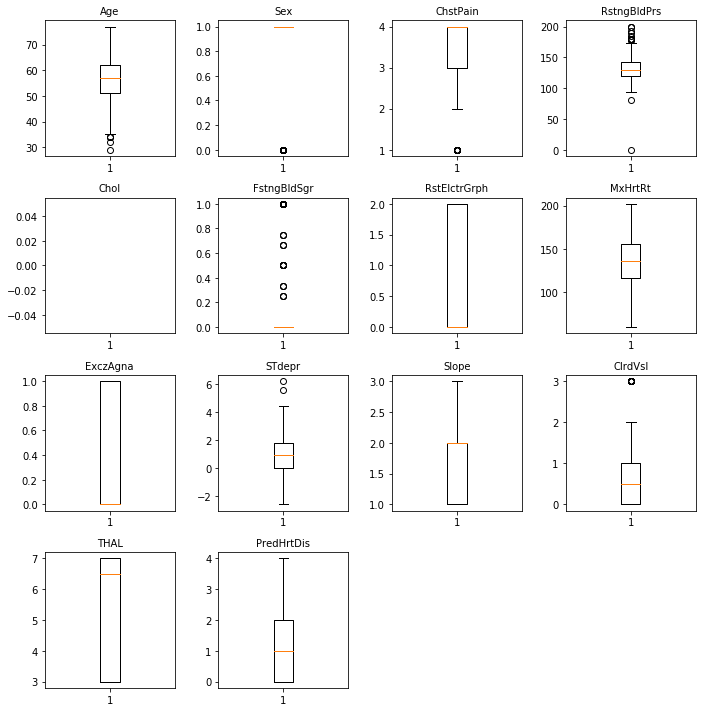

In [11]:
plt.figure(figsize=(10,10)) #check for outliers in column data
i = 1
#print(df.columns)
for column in df.columns: 
    plt.subplot(4,4,i)
    plt.boxplot(df[column])
    plt.title(df[column].name,fontsize=10)
    i+=1
plt.tight_layout()
plt.show() 

- seems like a handful of outliers spread throughout, lets clean them up a little by removine data farther than three standard deviations away from the mean.

In [12]:
for col in df: #remove data plus or minus 3 standard deviations away from mean
    df = df[((df[col] - df[col].mean()) / df[col].std()).abs() < 3] 

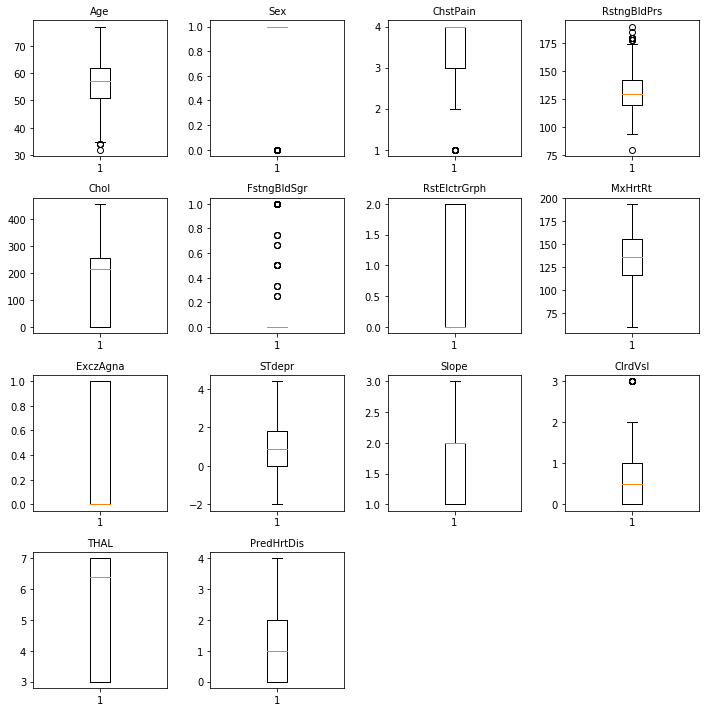

In [13]:
plt.figure(figsize=(10,10)) #visualize cleaned column data
i = 1
#print(df.columns)
for column in df.columns: 
    plt.subplot(4,4,i)
    plt.boxplot(df[column])
    plt.title(df[column].name,fontsize=10)
    i+=1
plt.tight_layout()
plt.show()

- while it didnt remove ever outier from the column data, we see most of the outliers shared between the column data that does not seem to be normally distributed. Lets go on to visualize the data distributions in out data set.

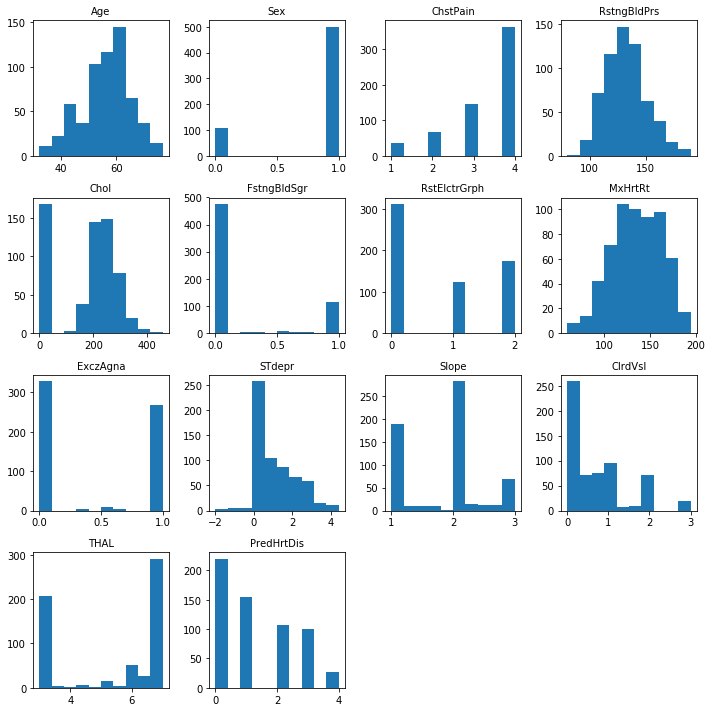

In [14]:
plt.figure(figsize=(10,10)) #visualize the distributions of column data
i = 1
#print(df.columns)
for column in df.columns: 
    plt.subplot(4,4,i)
    plt.hist(df[column])
    plt.title(df[column].name,fontsize=10)
    i+=1
plt.tight_layout()
plt.show()

- Not alot of column distributions resemble a normal curve, this is going to affect our regression model greatly. 

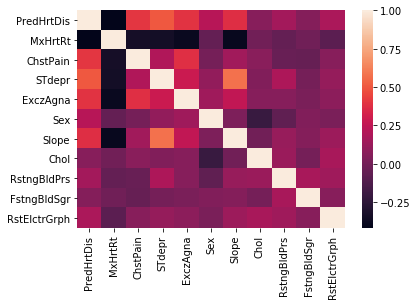

In [15]:
sns.heatmap(df_clv[['PredHrtDis','THAL','MxHrtRt','ChstPain','STdepr','ExczAgna','ClrdVsl','Sex','Slope','Chol','RstngBldPrs',
                    'FstngBldSgr','RstElctrGrph']].corr()) #visualize multicollinearity of column data


- Assessing for multicollinearity between the attributes, we select varibles with the lowest correlation values such that we can insure a model that predicts heart disease with the most statistical integrity. 

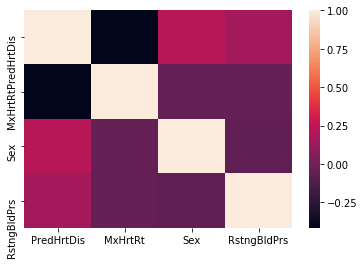

In [81]:
sns.heatmap(df_clv[['PredHrtDis','THAL','MxHrtRt','ClrdVsl','Sex','RstngBldPrs']].corr()) 
                                                                    #visualize multicollinearity of attributes

In [17]:
# Y is the target variable
Y = df['PredHrtDis']
# X is the feature set
X = df[['THAL','MxHrtRt','ClrdVsl','Sex','RstngBldPrs']]

In [18]:
X = sm.add_constant(X) #never forget to add constant to OLS model

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             PredHrtDis   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     53.90
Date:                Sun, 30 Jun 2019   Prob (F-statistic):           2.89e-46
Time:                        23:27:44   Log-Likelihood:                -878.47
No. Observations:                 609   AIC:                             1769.
Df Residuals:                     603   BIC:                             1795.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4256      0.444      0.960      0.338      -0.445       1.297
THAL            0.1643      0.027      6.150      0.000       0.112       0.217
MxHrtRt        -0.0108      0.002     -6.322      0.000      -0.014      -0.007
ClrdVsl         0.4085      0.055      7.435      0.000       0.301       0.516
Sex             0.3137      0.122      2.577      0.010       0.075       0.553
RstngBldPrs     0.0067      0.002      2.853      0.004       0.002       0.011
==============================================================================
Omnibus:                       14.775   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.320
Skew:                           0.374   Prob(JB):                     0.000471
Kurtosis:                       2.788   Cond. No.                     2.03e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Our LRM did not return a very high R score, although all of the coefficients were statistically significant.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)
                                                                                #split data 20% for testing holdout
scaler = StandardScaler() #standardaize the training and testing data
scaler.fit(X_train,X_test)
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

In [42]:
lrm = LinearRegression() 

lrm.fit(X_train, y_train)

# We are making predictions here
y_pred_train_lrm = lrm.predict(X_train)
y_pred_lrm = lrm.predict(X_test)

In [43]:
lr_score = cross_val_score(lrm,X_train, y_train, cv=4) #calculate prediction accuracy of the LRM
print("OLS Accuracy: %0.2f (+/- %0.2f)" % (lr_score.mean(), lr_score.std() * 2))

OLS Accuracy: 0.29 (+/- 0.18)


- As expected, accuracy levels are low with a wide variance. The target varible does not lend itself to regression modeling and thus alot of the variance in the data cannot be accounted for by this modeling method. 

In [44]:
def get_metrics(reg_model, x_train, y_train, x_test, y_test, y_preds_lrm): 
                                                                                #Calculate evaluation metrics for LRM
    print("R-squared of the model in training set is: {}".format(reg_model.score(x_train, y_train)))
    print("-----Test set statistics-----")
    print("R-squared of the model in test set is: {}".format(reg_model.score(x_test, y_test)))
    print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_pred_lrm)))
    print("Mean squared error of the prediction is: {}".format(mse(y_test, y_pred_lrm)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_pred_lrm)))
    #print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_pred_lrm) / y_test)) * 100))

get_metrics(lrm,X_train,y_train,X_test,y_test,y_pred_lrm)


R-squared of the model in training set is: 0.31355914226845283
-----Test set statistics-----
R-squared of the model in test set is: 0.26593434668627536
Mean absolute error of the prediction is: 0.814081082925504
Mean squared error of the prediction is: 1.0854150025617075
Root mean squared error of the prediction is: 1.041832521359219


- Although error metrics are low, the combination of poor accuracy and R score determine that linear regression modelingis the wrong choice for this target variable.

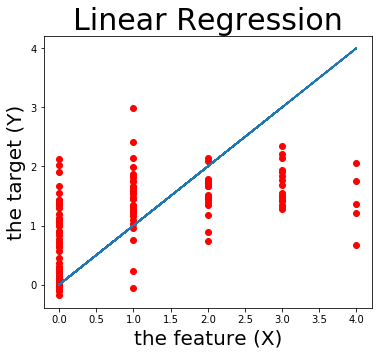

In [45]:
def get_predictplot(reg_model,y_test,y_preds): #visualize LRM predictions vs test data
    plt.figure(figsize=(20,5))

    plt.subplot(1,3,1)
    plt.scatter(y_test, y_pred_lrm, color="red")
    plt.plot(y_test, y_test)
    plt.title(reg_model, fontsize=30)
    plt.xlabel("the feature (X)", fontsize=20)
    plt.ylabel("the target (Y)", fontsize=20)
    

get_predictplot('Linear Regression', y_test, y_pred_lrm)

## KNN Modeling

- Since KNN is a classification technique, we may expect this method to perform more favorably than LRM.

In [46]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X, Y, test_size = 0.2, random_state = 465)
                                                                                  #split data 20% for testing holdout
scaler = StandardScaler() #standardaize the training and testing data 
scaler.fit(X_train_knn)

X_train_knn = scaler.transform(X_train_knn)  
X_test_knn = scaler.transform(X_test_knn)

- We create an aid to help us choose the K(neighbor) value that minimize the mean prediction error in the model.

In [49]:
error = []

for i in range(1, 50): # Calculating error for K values between 1 and 50
    knn = KNeighborsClassifier(n_neighbors=i,weights='distance')
    knn.fit(X_train_knn, y_train_knn)
    pred_i = knn.predict(X_test_knn)
    error.append(np.mean(pred_i != y_test_knn))

Text(0, 0.5, 'Mean Error')

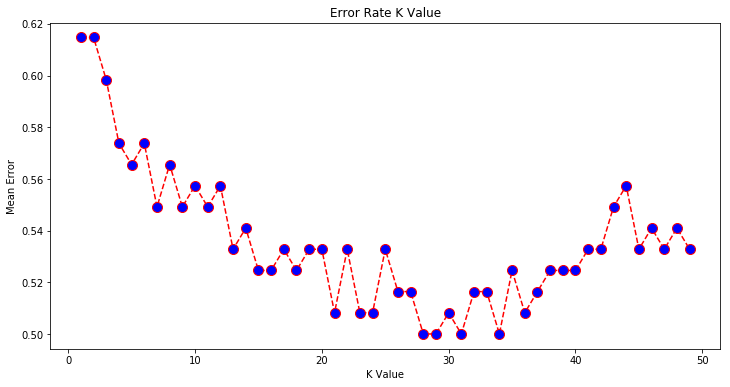

In [50]:
plt.figure(figsize=(12, 6)) #visualize mean prediction errors in relation to k number
plt.plot(range(1, 50), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error')

- Fromthe chart, it looks like K values of 28, 29, 31, and 34 are best to minimize prediciton errors.

In [76]:
from sklearn.neighbors import KNeighborsClassifier  

classifier = KNeighborsClassifier(n_neighbors=29,weights='distance') 
classifier.fit(X_train_knn, y_train_knn)  

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=29, p=2,
           weights='distance')

In [77]:
y_pred_knn = classifier.predict(X_test_knn)
print(classification_report(y_test_knn, y_pred_knn)) 

              precision    recall  f1-score   support

           0       0.73      0.70      0.71        53
           1       0.36      0.50      0.42        28
           2       0.25      0.25      0.25        20
           3       0.42      0.31      0.36        16
           4       0.00      0.00      0.00         5

   micro avg       0.50      0.50      0.50       122
   macro avg       0.35      0.35      0.35       122
weighted avg       0.49      0.50      0.49       122



In [78]:
knn_score = cross_val_score(classifier,X_train_knn, y_train_knn, cv=4) #calculate accuracy of the KNN classifier
print("KNN Accuracy: %0.2f (+/- %0.2f)" % (knn_score.mean(), knn_score.std() * 2))

KNN Accuracy: 0.41 (+/- 0.07)


- While not a terrible high accuracy value, KNN prediction accuracy is much higher and less prone to variance than LRM

In [79]:
get_metrics(knn,X_train_knn,y_train_knn,X_test_knn,y_test_knn,y_pred_knn)
                                                                    #calculate evaluation metrics of KNN classifier

R-squared of the model in training set is: 0.997946611909651
-----Test set statistics-----
R-squared of the model in test set is: 0.4672131147540984
Mean absolute error of the prediction is: 0.814081082925504
Mean squared error of the prediction is: 1.0854150025617075
Root mean squared error of the prediction is: 1.041832521359219


- However accurate, the KNN model's R scores highlight a huge amount of overfit error in the model. To regulate this metric we could try different values of K our use a different selection of indicators.

## Conclusion

    Over all, error evaluation between KNN and OLS remain similar. In this case the KNN modeling shows a better prediction accuracy value at 0.41 (+/- 0.07) than the Linear Regression accuracy at 0.29 (+/- 0.18). However, the KNN model's training R score equal to .997 and its correspoding testing R score at .467 signifies a large amount of overfitting error in the model. The linear model is less so with a train/test R score of .314/.266. 

    A visualization of the linear model's prediction vs test value plot shows that regression would be the incorrect prediction method for this data. Although the target data is a numerical value, it is not a continuous variable and would be better suited to a classifier modeling method. 
    
    Since the target variable was categorical, the KNN classifier works best over a regression model. It may be a different case however if the target variable was a continuous numerical value or if we needed to predicted a value outside the bounds of our training dataset.  

